In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("data/dataframes/QueryResults.csv")
data.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable <code...,<c#><floating-point><type-conversion><double><...,4,815,81370,NaN,13
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,<html><css><internet-explorer-7>,6,320,25200,NaN,7
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,<c#><.net><datetime>,9,2269,854214,NaN,76
3,jQuery / JavaScript How can I find the left in...,<p>Right now I am toying around with an idea i...,<javascript><jquery><html><css>,11285720,2,2751,NaN,3
4,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,11,1655,205481,NaN,42


In [2]:
#Affichage des informations du Dataframe
print(f'columns: {data.shape[1]} \nrows: {data.shape[0]}')

missing_values = (data.isna().sum() / data.shape[0]) * 100
print("missing values:")
for column, value in missing_values.items():
    if value > 0:
     print("-",column,value,"%")

duplicated_values = data.duplicated(subset="Body").sum()
print("duplicated body:",duplicated_values)

columns: 8 
rows: 50000
missing values:
- FavoriteCount 100.0 %
duplicated body: 0


In [3]:
# Suppression des colonnes inutiles et vides
data = data.drop(columns=["FavoriteCount", "Id"])

# Nettoyage des tags

In [4]:
# Nettoyage des tags, transformation en liste
def extract_tags(tag_string):
    tags = tag_string.split('<')[1:]
    tags = [tag.split('>')[0] for tag in tags]
    tags = [tag for tag in tags if len(tag) > 1]
    return tags

data['Tags'] = data['Tags'].apply(extract_tags)

exploded_df = data.explode('Tags')
unique_tags = exploded_df['Tags'].unique()
print("Nombre de tags uniques:", unique_tags.shape[0])

data.head()

Nombre de tags uniques: 17570


,Title,Body,Tags,Score,ViewCount,AnswerCount
0,How to convert Decimal to Double in C#?,<p>I want to assign the decimal variable <code...,"[c#, floating-point, type-conversion, double, ...",815,81370,13
1,Why did the width collapse in the percentage w...,<p>I have an absolutely positioned <code>div</...,"[html, css, internet-explorer-7]",320,25200,7
2,How do I calculate someone's age based on a Da...,<p>Given a <code>DateTime</code> representing ...,"[c#, .net, datetime]",2269,854214,76
3,jQuery / JavaScript How can I find the left in...,<p>Right now I am toying around with an idea i...,"[javascript, jquery, html, css]",2,2751,3
4,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,"[c#, datetime, time, datediff, relative-time-s...",1655,205481,42


### Calcul de scores pour les tags

In [5]:
from sklearn.preprocessing import StandardScaler

tag_performance = exploded_df.groupby('Tags').agg({'ViewCount': 'sum', 'Score': 'sum', 'AnswerCount': 'sum'}).reset_index()

scaler = StandardScaler()
tag_performance[['Views_std', 'Score_std', 'Answer_std']] = scaler.fit_transform(tag_performance[['ViewCount', 'Score', 'AnswerCount']])
tag_performance['composite_score'] = tag_performance['Views_std'] + tag_performance['Score_std'] + tag_performance['Answer_std']

tag_performance = tag_performance.drop(columns=['ViewCount', 'Score', 'AnswerCount'])

# Trier par score composite et sélectionner les 100 premiers
top_100_tags = tag_performance.sort_values(by='composite_score', ascending=False).head(100)
top_200_tags = tag_performance.sort_values(by='composite_score', ascending=False).head(200)

top_100_tags

,Tags,Views_std,Score_std,Answer_std,composite_score
2302,c#,48.609109,55.947359,55.991151,160.547620
12120,python,55.414058,56.151224,43.692401,155.257683
7734,java,47.993051,43.181512,49.145192,140.319754
7796,javascript,39.050779,33.763432,47.656939,120.471150
7,.net,29.488055,37.561006,32.261798,99.310860
...,...,...,...,...,...
8701,linq,2.314179,2.687088,3.261552,8.262819
297,ajax,2.132365,1.596056,4.501762,8.230182
17255,xcode,1.928794,2.300693,3.943668,8.173155
9288,merge,2.676682,4.392678,1.029174,8.098534


### Tags les plus utilisés

<Axes: title={'center': 'Top 50 des tags les plus fréquents'}, xlabel='Word', ylabel='Frequency'>

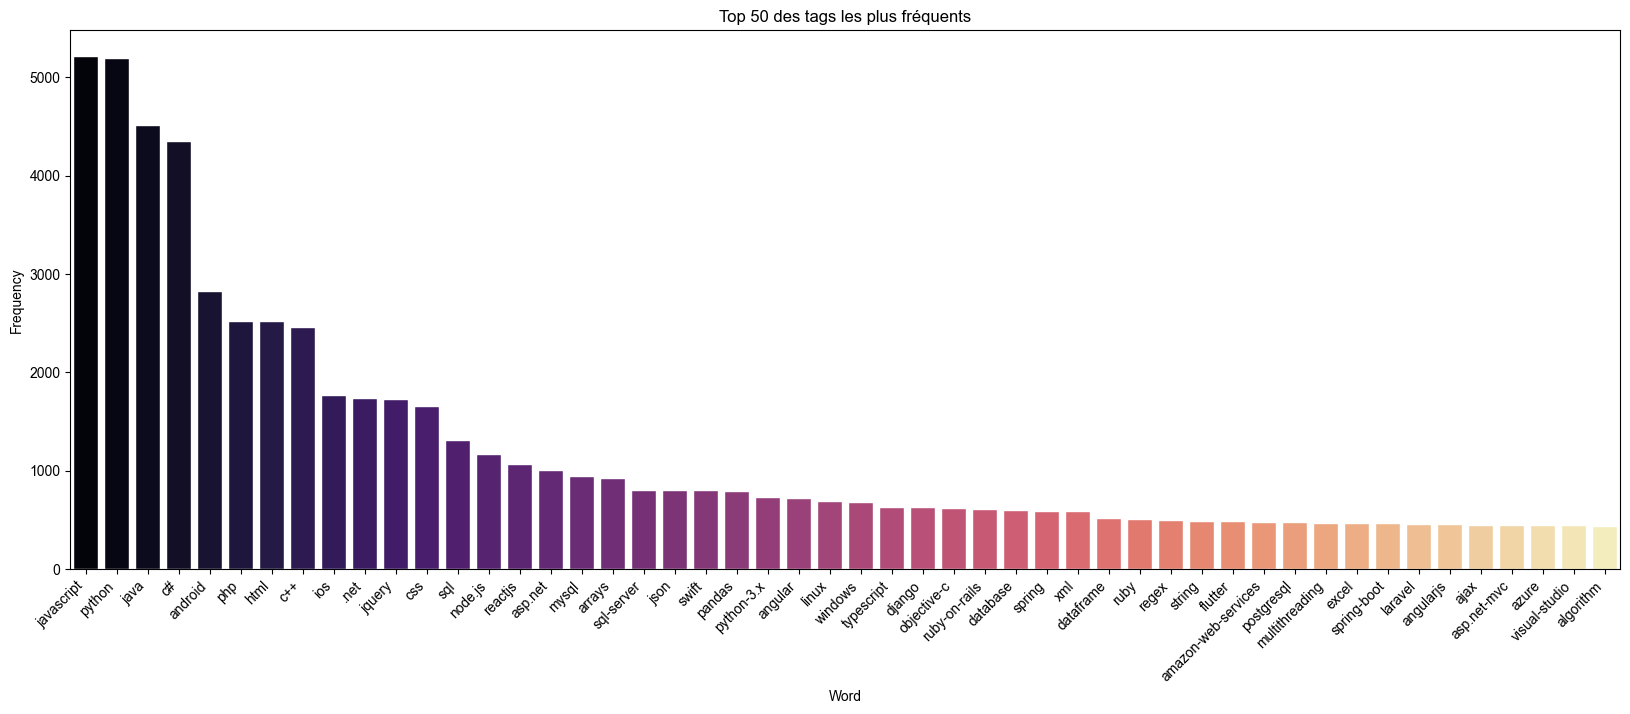

In [6]:
import nltk

fdist = nltk.FreqDist(exploded_df['Tags'])
tags_corpus_df = pd.DataFrame({'Word':list(fdist.keys()), 'Frequency':list(fdist.values())})
tags_df_50 = tags_corpus_df.nlargest(columns="Frequency", n=50)
tags_df_20 = tags_corpus_df.nlargest(columns="Frequency", n=20)

plt.figure(figsize=(20,7))
plt.title("Top 50 des tags les plus fréquents")
plt.xticks(rotation=45, ha='right')
sns.set_style("darkgrid")
sns.barplot(x=tags_df_50['Word'], y=tags_df_50['Frequency'], palette='magma', legend=False, hue=tags_df_50['Word'])

In [7]:
tags_df_20.head()

,Word,Frequency
10,javascript,5214
117,python,5197
28,java,4510
0,c#,4346
135,android,2829


In [ ]:
tags_df_50.to_csv('data/dataframes/most_used_tags_50.csv', index=False)
tags_df_20.to_csv('data/dataframes/most_used_tags_20.csv', index=False)

# Nettoyage Title & Body

In [9]:
# data = data.sample(10000)
data = data.drop(columns=['ViewCount', 'Score', 'AnswerCount'])

In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from bs4 import BeautifulSoup
import re
from bs4 import MarkupResemblesLocatorWarning
import warnings

warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

# Téléchargements nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Déclarations
lemmatizer = WordNetLemmatizer()
sw = set(stopwords.words('english'))

# Fonction de nettoyage de texte brut HTML et caractères spéciaux
def clean_text(text):

    cleaned_text = BeautifulSoup(text, "lxml").get_text()
    cleaned_text = cleaned_text.lower().replace('c#', 'csharpxxx').replace('c #', 'csharpxxx').replace('c ++', 'cplusxxx').replace('c++', 'cplusxxx')
    cleaned_text = re.sub(r"[^a-zA-Z\s]+|(http\S+)|(www\.\S+)|\d+", ' ', cleaned_text)
    return cleaned_text

# Application du nettoyage et du traitement
data["Title"] = data["Title"].apply(clean_text)
data["Body"] = data["Body"].apply(clean_text)

# Affichage des résultats
data.head()


[nltk_data] Downloading package punkt to /Users/laurent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laurent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/laurent/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/laurent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Title,Body,Tags
0,how to convert decimal to double in csharpxxx,i want to assign the decimal variable trans to...,"[c#, floating-point, type-conversion, double, ..."
1,why did the width collapse in the percentage w...,i have an absolutely positioned div containing...,"[html, css, internet-explorer-7]"
2,how do i calculate someone s age based on a da...,given a datetime representing a person s birth...,"[c#, .net, datetime]"
3,jquery javascript how can i find the left in...,right now i am toying around with an idea in m...,"[javascript, jquery, html, css]"
4,calculate relative time in csharpxxx,given a specific datetime value how do i disp...,"[c#, datetime, time, datediff, relative-time-s..."


In [11]:
# Mapping des étiquettes POS
wordnet_map = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ}

# Lemmatisation avec prise en compte du POS
def lemma_fct(list_words):
    pos_tags = nltk.pos_tag(list_words)
    lem_w = [lemmatizer.lemmatize(word, pos=wordnet_map.get(pos[0].upper(), wordnet.NOUN)) for word, pos in pos_tags]
    return lem_w

# Correction des mots "csharpxxx" et "cplusxxx"
def c_sharp_pp(words_list):
    return [
        word.replace("sharpxxx", "#").replace("plusxxx", "++")
        if "sharpxxx" in word or "plusxxx" in word else word
        for word in words_list
    ]

# Pipeline complet de traitement du texte
def process_text(text, stopwords):
    tokens = word_tokenize(text)
    if stopwords:
        tokens = [word for word in tokens if word not in sw]
    tokens = c_sharp_pp(tokens)
    tokens = lemma_fct(tokens)
    return ' '.join(tokens)


# Application de la fonction du pipeline de traitement à Title et Body
data["Title"] = data["Title"].apply(lambda x: process_text(x, stopwords=True))
data["Body"] = data["Body"].apply(lambda x: process_text(x, stopwords=True))

# Fusion des features Title et Body en un seul document
data['Merged_doc']= data.apply(lambda x : x['Title']+' '+x['Body'], axis=1)
data = data.drop(columns=['Title', 'Body'])
data.head()

,Tags,Merged_doc
0,"[c#, floating-point, type-conversion, double, ...",convert decimal double c# want assign decimal ...
1,"[html, css, internet-explorer-7]",width collapse percentage width child element ...
2,"[c#, .net, datetime]",calculate someone age base datetime type birth...
3,"[javascript, jquery, html, css]",jquery javascript find left inner edge element...
4,"[c#, datetime, time, datediff, relative-time-s...",calculate relative time c# give specific datet...


In [12]:
# Nombre de mots uniques dans "Merged_doc"
corpus =' '.join([text for text in data['Merged_doc']])
corpus_copy = corpus.split()
print("Nombre de mots uniques dans le corpus", len(set(corpus_copy)))

Nombre de mots uniques dans le corpus 208879


<Axes: xlabel='Word', ylabel='Frequency'>

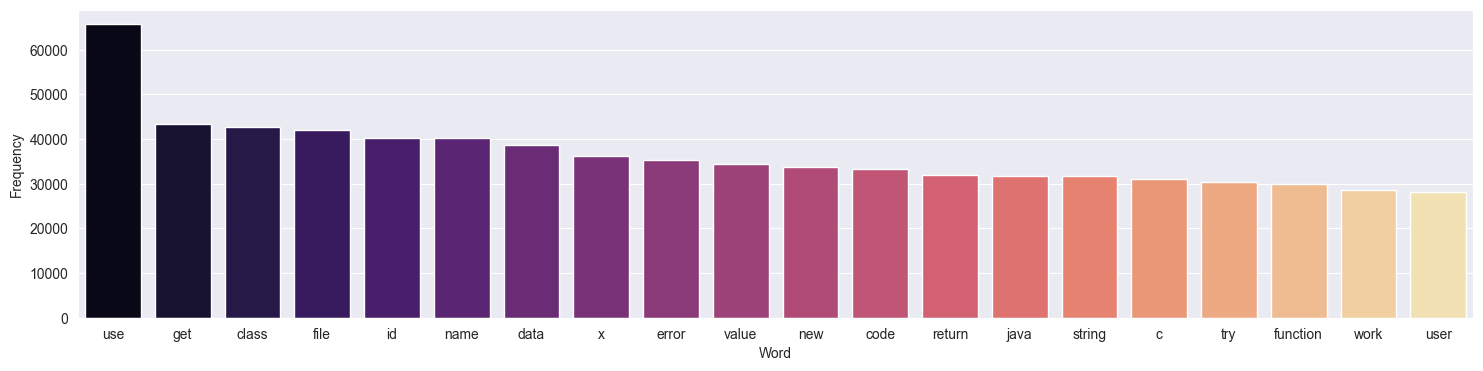

In [13]:
fdist = nltk.FreqDist(corpus_copy)
words_corpus_df = pd.DataFrame({'Word':list(fdist.keys()), 'Frequency':list(fdist.values())})

# selecting top 20 most frequent words
df1 = words_corpus_df.nlargest(columns="Frequency", n=20)

# visualize words and frequencies

plt.figure(figsize=(18,4))
sns.set_style("darkgrid")
sns.barplot(x=df1['Word'], y=df1['Frequency'], palette='magma', legend=False, hue=df1['Word'])

In [14]:
words_corpus_df.nlargest(7, 'Frequency')

,Word,Frequency
33,use,65683
149,get,43448
226,class,42731
198,file,42070
401,id,40355
427,name,40354
194,data,38612


In [15]:
tags_reference = set(tags_df_20['Word'])

data['Tags'] = data['Tags'].apply(lambda tags: [tag for tag in tags if tag in tags_reference])

data.head()

,Tags,Merged_doc
0,[c#],convert decimal double c# want assign decimal ...
1,"[html, css]",width collapse percentage width child element ...
2,"[c#, .net]",calculate someone age base datetime type birth...
3,"[javascript, jquery, html, css]",jquery javascript find left inner edge element...
4,[c#],calculate relative time c# give specific datet...


In [ ]:
data.to_csv('data/dataframes/cleaned_dataframe.csv', index=False)